# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

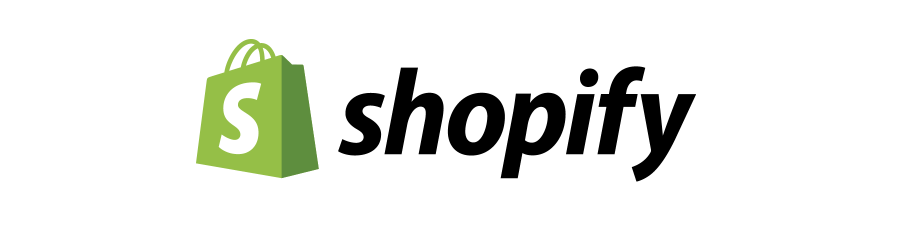

### Project Table of Contents: 
<br> 
    
**I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

**IV. PREPROCESSING AND MODELLING**
- 1. Linear Models
- 2. Classification Models


## Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [43]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss,matthews_corrcoef

from io import StringIO 
from IPython.display import Image,HTML 
import pydotplus
import graphviz
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

## Drop all non-repeat customers
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

In [4]:
## We change the pfw_spent column and create a new target column: repeat
customer_cltv['repeat'] = np.where(customer_cltv['pfw_spent'] > 0,1,0)
customer_cltv.drop(columns='pfw_spent',inplace=True)
customer_cltv.head()

,CustomerID,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range,repeat
0,Anonymous13455,1,1,50.0,0,6,0,M,0,0,MW,high,1
1,Anonymous2142,1,1,48.0,0,5,0,L,0,0,NE,high,1
2,Anonymous4843,2,2,96.0,0,10,0,S,1,0,W,high,1
3,Anonymous11225,1,1,16.0,0,1,1,No size,0,0,MW,low,1
4,Anonymous540,1,1,50.0,0,1,0,XS,0,0,W,high,1


<br> **Drop variables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- **fw_nb_items** is highly correlated with fw_total_spent (c=0.94)
- **fw_nb_orders** is very unbalanced (~ 95% customers only made 1 order the first week)
- **region** was found to be insignificant based on several steps of statistical analysis
- **fw_purchased_accessory** is logically redundant with first_item_size


In [5]:
customer_cltv.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- **first_order_month** can be modified to be 2 categories: February-June vs rest of the year
- **first_item size** can be modified to be 2 categories: Large Size and Smaller Sizes

In [6]:
## First Item Month 
customer_cltv['first_order_feb_june'] = customer_cltv['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv['first_order_feb_june'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_order_month'], inplace = True)

## First Item Size: 
customer_cltv['large_size'] = customer_cltv['first_item_size'].apply(lambda x: x in ['XL','L','M'])
customer_cltv['large_size'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_item_size'], inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_item_price_range,repeat,first_order_feb_june,large_size
0,Anonymous13455,50.0,0,0,0,high,1,1,1
1,Anonymous2142,48.0,0,0,0,high,1,1,1
2,Anonymous4843,96.0,0,1,0,high,1,0,0
3,Anonymous11225,16.0,0,0,0,low,1,0,0
4,Anonymous540,50.0,0,0,0,high,1,0,0


#### We create dummy variables for our categorical variables.

In [7]:
## We create dummy variables for prize range of items. 
categorical_cols = ['first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv[categorical_cols].astype(str),drop_first=True)
customer_cltv = pd.concat([customer_cltv,dummies_encoded], axis =1)
customer_cltv.drop(columns=['first_item_price_range'],inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,repeat,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,50.0,0,0,0,1,1,1,0,0
1,Anonymous2142,48.0,0,0,0,1,1,1,0,0
2,Anonymous4843,96.0,0,1,0,1,0,0,0,0
3,Anonymous11225,16.0,0,0,0,1,0,0,1,0
4,Anonymous540,50.0,0,0,0,1,0,0,0,0


In [8]:
## We get our feature variables and target variables
X = customer_cltv.drop(columns=['CustomerID','repeat'])
y = customer_cltv['repeat']
print(X.shape, y.shape)

(10590, 8) (10590,)


In [9]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,1,1,0,0
1,-0.389530,0,0,0,1,1,0,0
2,0.623424,0,1,0,0,0,0,0
3,-1.064833,0,0,0,0,0,1,0
4,-0.347324,0,0,0,0,0,0,0


0    7714
1    2876
Name: repeat, dtype: int64


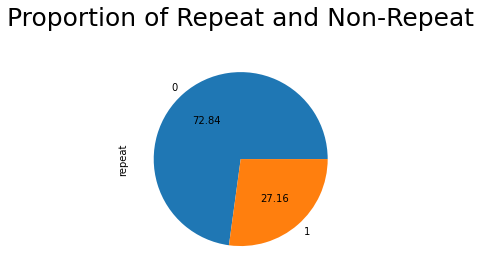

In [10]:
## Look at the balance of the data: Only 27% of our customers are repeat, the non-repeats are over represented.
## This is an example of an imbalanced dataset. 
print(y.value_counts())
y.value_counts().plot.pie(autopct='%.2f')
plt.title('Proportion of Repeat and Non-Repeat', pad =25, fontsize =25)
plt.show()

In [11]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 8) (2648, 8) (7942,) (2648,)


# Classification Models
<br> In the previous models, our target feature was **continuous**. We will be treating pwf as a **discrete**.
<br> **We will be using 7 different classification models:**
- 1) Logistic Regression 
- 2) Random Forests
- 3) Gradient Boosting
- 4) SVC 
- 5) K-NN
- 6) Naive Bayes
- 7) Stochastic Gradient Descent

## 1) Logistic Regression 

In [12]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1],
             'penalty':['none','l1','l2','elasticnet']
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
lr_cv.fit(X_train,y_train)

## We print the metrics: 
print('Best Estimator:' +str(lr_cv.best_estimator_))
print('Best Params:' +str(lr_cv.best_params_))
print('Best Score:' +str(lr_cv.best_score_))

## With the best parameters, we re-instantiate the model, fit and predict the outcomes. 
best_lreg = LogisticRegression(C = 0.01, l1_ratio= 0, penalty = 'l2')

Best Estimator:LogisticRegression(C=0.01, l1_ratio=0)
Best Params:{'C': 0.01, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5936427837013756


## 2 Random Forests:

In [13]:
'''
## Prior to using GridSeachCV, we can see the effect of n_estimators on testing accuracy. 
scores =[]
for k in range(1, 200):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    y_pred_rf = rfc.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred_rf))

# plot the relationship between K and testing accuracy
plt.figure(figsize=(14,7))
plt.plot(range(1, 200), scores, color ='g', linestyle ='--')
plt.xlabel('N Estimator Value in RF Model')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy across multiple n_estimator values', fontsize = 25, pad =20)
plt.show()
## Code inspired from: https://stackoverflow.com/questions/60768008/how-to-choose-n-estimators-in-randomforestclassifier
'''

"\n## Prior to using GridSeachCV, we can see the effect of n_estimators on testing accuracy. \nscores =[]\nfor k in range(1, 200):\n    rfc = RandomForestClassifier(n_estimators=k)\n    rfc.fit(X_train, y_train)\n    y_pred_rf = rfc.predict(X_test)\n    scores.append(accuracy_score(y_test, y_pred_rf))\n\n# plot the relationship between K and testing accuracy\nplt.figure(figsize=(14,7))\nplt.plot(range(1, 200), scores, color ='g', linestyle ='--')\nplt.xlabel('N Estimator Value in RF Model')\nplt.ylabel('Testing Accuracy')\nplt.title('Testing Accuracy across multiple n_estimator values', fontsize = 25, pad =20)\nplt.show()\n## Code inspired from: https://stackoverflow.com/questions/60768008/how-to-choose-n-estimators-in-randomforestclassifier\n"

In [14]:
## We use GridSearchCV to find the best hyperparameters of RandomForest. 
'''
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_features': ['sqrt', 'auto', 'log2'],
    'criterion': ['gini','entropy'],
    'max_depth' : [2,4,6,8],
    'bootstrap':['False', 'True']
}

rfc_GS = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc')
rfc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(rfc_GS.best_estimator_))
print('Best Params:' +str(rfc_GS.best_params_))
print('Best Score:' +str(rfc_GS.best_score_))
'''
## The findings for the above is as follows below: 

'''
Best Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='log2',
                       n_estimators=50, random_state=42)
Best Params:{'bootstrap': 'False', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 50}
Best Score:0.5980930489388412
'''

"\nBest Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='log2',\n                       n_estimators=50, random_state=42)\nBest Params:{'bootstrap': 'False', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 50}\nBest Score:0.5980930489388412\n"

In [15]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
rfc_best = RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= 4, 
                                  max_features= 'log2', n_estimators= 50, random_state = 42)

In [16]:
## We can see the feature importances in the model below...
rfc_best.fit(X_train,y_train)
features_best = pd.DataFrame(rfc_best.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
features_best

,importance
fw_total_spent,0.600996
first_order_feb_june,0.134652
first_item_price_range_low,0.090815
large_size,0.079138
fw_used_coupon,0.029827
first_item_price_range_medium,0.029657
accepts_marketing,0.019634
wealthy_zip,0.015280


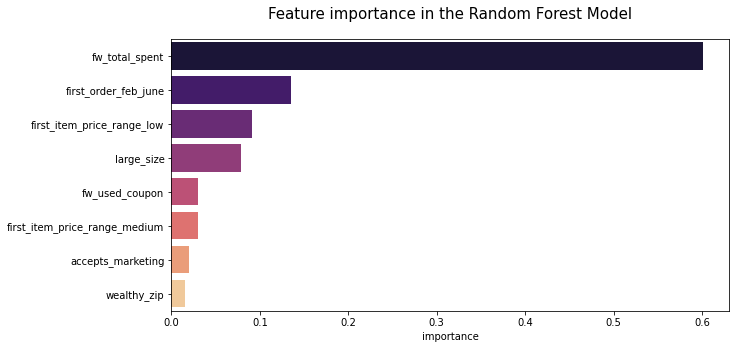

In [17]:
## ... and we can plot them. 
plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features_best.index, x = features_best['importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()

## 3) Gradient Boosting:

In [18]:
## We use GridSearchCV to find the best hyperparameters for Gradient Boosting
'''
gbc = GradientBoostingClassifier(random_state = 42)
param_grid = { 
    'loss': ['exponential','deviance'],
    'n_estimators': [1,2,5,10,20,100],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth' : [2,6,8,10],
}

gbc_GS = GridSearchCV(gbc, param_grid, cv=5, scoring='roc_auc')
gbc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(gbc_GS.best_estimator_))
print('Best Params:' +str(gbc_GS.best_params_))
print('Best Score:' +str(gbc_GS.best_score_))
'''

## The findings for the above is as follows below: 
'''
Best Estimator:GradientBoostingClassifier(max_depth=2, n_estimators=20, random_state=42)
Best Params:{'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 20}
Best Score:0.5969885566772868
'''

"\nBest Estimator:GradientBoostingClassifier(max_depth=2, n_estimators=20, random_state=42)\nBest Params:{'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 20}\nBest Score:0.5969885566772868\n"

In [19]:
## We  fit the Predictor.
gbc_best = GradientBoostingClassifier(criterion= 'friedman_mse', max_depth= 2, 
                                      max_features= 'sqrt', n_estimators= 20, loss ='deviance',
                                      random_state = 42)

## 4) SVC

In [20]:
'''
## We use GridSearch to get the best parameters for SVC
svc = SVC(random_state = 42)
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
             }

svc_GS = GridSearchCV(svc, param_grid, scoring='roc_auc')
svc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(svc_GS.best_estimator_))
print('Best Params:' +str(svc_GS.best_params_))
print('Best Score:' +str(svc_GS.best_score_))
'''

## This is the result of GridSearchCV (takes close to 30 min to run): 
'''
Best Estimator:SVC(C=0.1, gamma=0.0001, random_state=42)
Best Params:{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:0.5902888828468549
'''
## We re-instantiate SVC with the best parameters.
svc_best = SVC(C=0.1, gamma=0.0001, kernel = 'rbf',random_state = 42, probability = True)

## 5) K-Nearest Neighbors

In [21]:
## We useGridSearch to get the best knn hyperparameters
'''
knn = KNeighborsClassifier()
k_range  = list(range(1,20))

parameters_KNN = {
    'n_neighbors': list(range(1,31)),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
     }

knn_GS = GridSearchCV(knn, parameters_KNN, cv=10, scoring='roc_auc', return_train_score=False, verbose=1)
knn_GS.fit(X_train,y_train)

print('Best Estimator:' +str(knn_GS.best_estimator_))
print('Best Params:' +str(knn_GS.best_params_))
print('Best Score:' +str(knn_GS.best_score_))
'''

## Results of GridSearch CV:  
'''
Best Estimator:KNeighborsClassifier(leaf_size=40, n_neighbors=22)
Best Params:{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 22, 'p': 2, 'weights': 'uniform'}
Best Score:0.586510812526592
'''
## We re-instantiate with the best parameters. 
knn_best = KNeighborsClassifier(leaf_size= 40, metric= 'minkowski', n_neighbors= 22, p= 2, weights= 'uniform')

## 6) Naive Bayes

In [22]:
## We use GridSearch CV to get the best parameters to maximize the roc_auc
nb = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_GS = GridSearchCV(nb, param_grid = params_NB , cv=10, scoring='roc_auc', return_train_score=False, verbose=1)
nb_GS.fit(X_train,y_train)

## We print out the result
print('Best Estimator:' +str(nb_GS.best_estimator_))
print('Best Params:' +str(nb_GS.best_params_))
print('Best Score:' +str(nb_GS.best_score_))
## We refit the model with the best parameters found above. 
nb_best = GaussianNB(var_smoothing=1.0)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Estimator:GaussianNB(var_smoothing=1.0)
Best Params:{'var_smoothing': 1.0}
Best Score:0.5906162235134371


## 7) Stochastic Gradient Descent

In [23]:
## We use GridSearchCV to find the best parameters to maximize roc_auc. 
sgd = SGDClassifier(random_state = 42)
param_grid = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]
}
sgd_GS = GridSearchCV(sgd, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
sgd_GS.fit(X_train,y_train)

## We print out thr results. 
print('Best Estimator:' +str(sgd_GS.best_estimator_))
print('Best Params:' +str(sgd_GS.best_params_))
print('Best Score:' +str(sgd_GS.best_score_))

## We fit the SGDClassifier with the best parameters found above. 
sgd_best = SGDClassifier(alpha= 0.01, l1_ratio= 0, loss = 'log', penalty = 'elasticnet', random_state = 42)

Best Estimator:SGDClassifier(alpha=0.01, l1_ratio=0, loss='log', penalty='elasticnet',
              random_state=42)
Best Params:{'alpha': 0.01, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet'}
Best Score:0.5937533403869532


## 8) ADABOOST 

In [24]:
## We use GridSearchCV to find the best parameters to maximize roc_auc. 
'''
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),random_state=42)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

ada_GS = GridSearchCV(ada, parameters,verbose=3,scoring='roc_auc',n_jobs=-1)
ada_GS.fit(X_train,y_train)

print('Best Estimator:' +str(ada_GS.best_estimator_))
print('Best Params:' +str(ada_GS.best_params_))
print('Best Score:' +str(ada_GS.best_score_))
'''
## This is what we get: 
'''
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5,
                                                         random_state=42),
                   learning_rate=0.01, n_estimators=250, random_state=42)
Best Params:{'base_estimator__max_depth': 2, 'base_estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 
'n_estimators': 250}
Best Score:0.5979802017920516
'''
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=5,random_state=42),
                                                           learning_rate=0.01, n_estimators=250, random_state=42)

## 9 ) XGBOOST 

In [25]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=1, seed = 42)
clf_xgb.fit(X_train,y_train, verbose = True, early_stopping_rounds =10, eval_metric ='auc', eval_set = [(X_test,y_test)])

[0]	validation_0-auc:0.59355
[1]	validation_0-auc:0.59743
[2]	validation_0-auc:0.59248
[3]	validation_0-auc:0.59161
[4]	validation_0-auc:0.59017
[5]	validation_0-auc:0.59250
[6]	validation_0-auc:0.59066
[7]	validation_0-auc:0.59145
[8]	validation_0-auc:0.59273
[9]	validation_0-auc:0.59199
[10]	validation_0-auc:0.59081


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

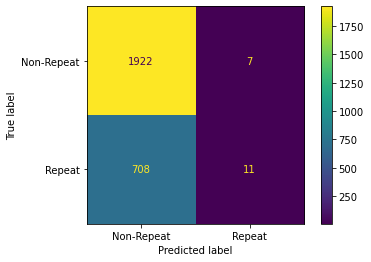

In [26]:
plot_confusion_matrix(clf_xgb,X_test,y_test, values_format ='d',display_labels=['Non-Repeat','Repeat'])
plt.show()

In [27]:
## NOTE: When data are imbalanced, the XGBoost manual says...
## If you care only about the overall performance metric (AUC) of your prediction
##     * Balance the positive and negative weights via scale_pos_weight
##     * Use AUC for evaluation
## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
## in order to optimize parameters in a short period of time.

# ROUND 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1,3,5]
}
# Output: {'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 1}

## ROUND 2
#'''
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0.25],
    'reg_lambda': [10.0, 20, 100],
    'scale_pos_weight': [1]
}
#'''
## Output: 

## NOTE: To speed up cross validiation, and to further prevent overfitting.
## We are only using a random subset of the data (90%) and are only
## using a random subset of the features (columns) (50%) per tree.
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                eval_metric="auc", 
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                                use_label_encoder=False),
    param_grid=param_grid,
    scoring='roc_auc', 
    verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10,                
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)
print(optimal_params.best_estimator_)
print(optimal_params.best_score_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 100, 'scale_pos_weight': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0.25,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=100, scale_pos_weight=1,
              seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)
0.5947916060884986


In [28]:
xgb_best = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="auc", 
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=3,
                        reg_lambda=20,
                        scale_pos_weight=1,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
xgb_best.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.56787
[1]	validation_0-auc:0.56839
[2]	validation_0-auc:0.58190
[3]	validation_0-auc:0.58486
[4]	validation_0-auc:0.58970
[5]	validation_0-auc:0.59006
[6]	validation_0-auc:0.59606
[7]	validation_0-auc:0.59655
[8]	validation_0-auc:0.59956
[9]	validation_0-auc:0.60001
[10]	validation_0-auc:0.60035
[11]	validation_0-auc:0.60213
[12]	validation_0-auc:0.60097
[13]	validation_0-auc:0.60036
[14]	validation_0-auc:0.60012
[15]	validation_0-auc:0.60106
[16]	validation_0-auc:0.60195
[17]	validation_0-auc:0.60282
[18]	validation_0-auc:0.60282
[19]	validation_0-auc:0.60493
[20]	validation_0-auc:0.60458
[21]	validation_0-auc:0.60406
[22]	validation_0-auc:0.60444
[23]	validation_0-auc:0.60522
[24]	validation_0-auc:0.60484
[25]	validation_0-auc:0.60558
[26]	validation_0-auc:0.60499
[27]	validation_0-auc:0.60579
[28]	validation_0-auc:0.60625
[29]	validation_0-auc:0.60653
[30]	validation_0-auc:0.60630
[31]	validation_0-auc:0.60561
[32]	validation_0-auc:0.60564
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0.25,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=20, scale_pos_weight=1,
              seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

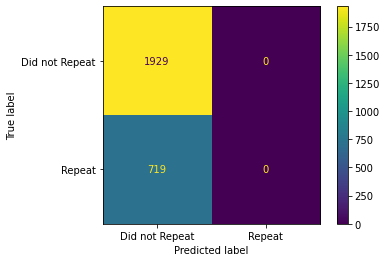

In [29]:
plot_confusion_matrix(xgb_best, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not Repeat", "Repeat"])
plt.show()

## Plotting ROC and AUC

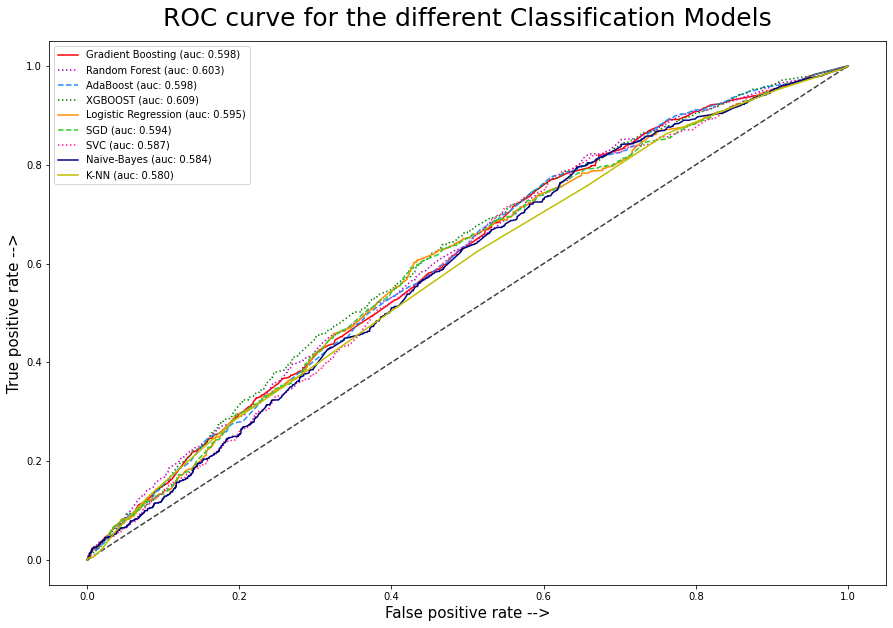

In [30]:
## We plot the ROC and AUC 
names = ["Gradient Boosting","Random Forest",'AdaBoost',"XGBOOST","Logistic Regression","SGD","SVC","Naive-Bayes","K-NN"]
clfs = [gbc_best,rfc_best,ada_best,xgb_best,best_lreg,sgd_best,svc_best,nb_best,knn_best]

## Parameters for the plotting 
linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))
counter = 0
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    #print("Roc AUC:"+name, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro')) ## Can uncomment
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name+ ' (auc: %0.3f)' %roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro'),
             linestyle=linestyles[counter], c=colors[counter])
    counter += 1
## Plot a straight line that goes throug
lims = [np.min([0.0, 0.0]),  np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='black', linestyle ='--')

plt.xlabel('False positive rate -->', fontsize = 15)
plt.ylabel('True positive rate -->', fontsize = 15)
plt.title('ROC curve for the different Classification Models', pad =15, fontsize = 25)
plt.legend(loc='best')
plt.savefig('roc_auc_classification_no_resampling.png')
plt.show()  

## Evaluating our Models and Plotting the Confusion Matrices: 

Gradient Boosting Model
ROC_AUC_SCORE: 0.598
Accuracy: 0.728
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


Random Forest Model
ROC_AUC_SCORE: 0.603
Accuracy: 0.729
Precision: 1.0
Recall: 0.001
F1-Score: 0.003


Logistic Regression Model
ROC_AUC_SCORE: 0.595
Accuracy: 0.73
Precision: 0.636
Recall: 0.01
F1-Score: 0.019


SVC Model
ROC_AUC_SCORE: 0.587
Accuracy: 0.728
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


SGD Model
ROC_AUC_SCORE: 0.594
Accuracy: 0.73
Precision: 0.636
Recall: 0.01
F1-Score: 0.019


Naive-Bayes Model
ROC_AUC_SCORE: 0.584
Accuracy: 0.73
Precision: 0.556
Recall: 0.021
F1-Score: 0.04


K-NN Model
ROC_AUC_SCORE: 0.58
Accuracy: 0.721
Precision: 0.294
Recall: 0.021
F1-Score: 0.039


AdaBoost Model
ROC_AUC_SCORE: 0.598
Accuracy: 0.729
Precision: 0.667
Recall: 0.003
F1-Score: 0.006


XGBOOST Model
ROC_AUC_SCORE: 0.609
Accuracy: 0.729
Precision: 0.583
Recall: 0.01
F1-Score: 0.019




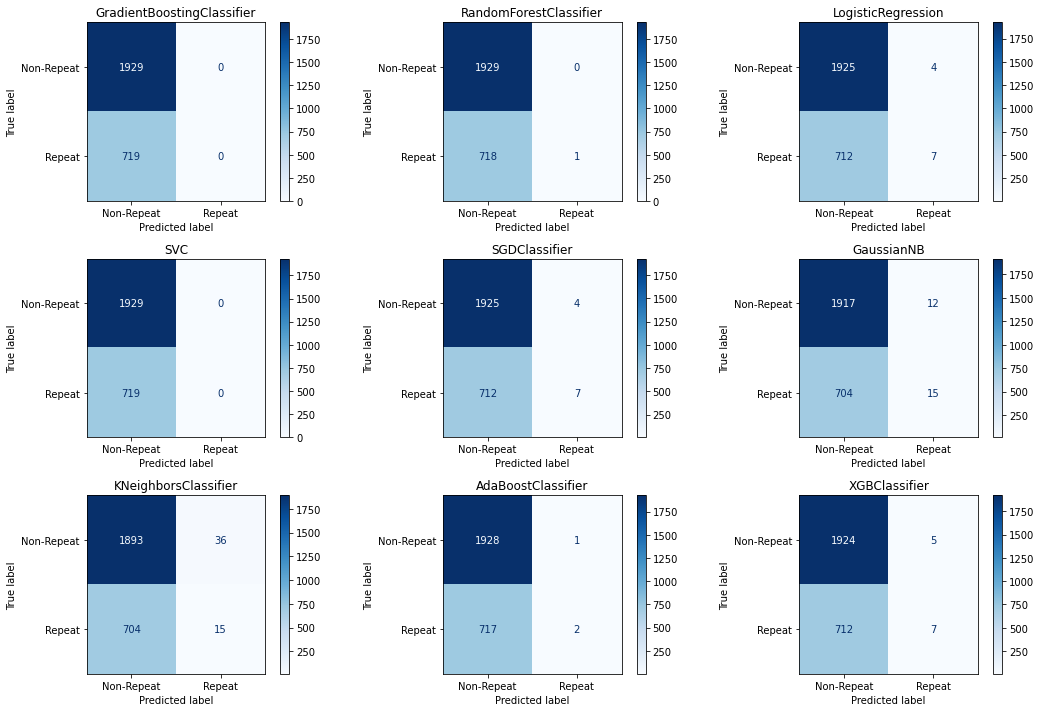

In [31]:
names = ["Gradient Boosting","Random Forest","Logistic Regression","SVC","SGD","Naive-Bayes","K-NN","AdaBoost","XGBOOST"]
models = [gbc_best,rfc_best,best_lreg,svc_best,sgd_best,nb_best,knn_best,ada_best,xgb_best]

counter = 0
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('{} Model'.format(names[counter]))
    print('ROC_AUC_SCORE: ' + str(round(roc_auc,3)))
    print('Accuracy: ' + str(round(accuracy_score(y_test,y_pred),3)))
    print('Precision: '+ str(round(precision_score(y_test,y_pred),3)))
    print('Recall: ' + str(round(recall_score(y_test,y_pred),3)))
    print('F1-Score: ' + str(round(f1_score(y_test,y_pred),3)))
    print("\n")
    counter +=1
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(model, 
                            X_test, 
                            y_test, 
                            ax=ax, 
                            cmap='Blues',
                            display_labels=['Non-Repeat','Repeat'])
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()

## Code Partially Inspired from:
#https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix

## Visualizing the Precision / Recall Tradeoff

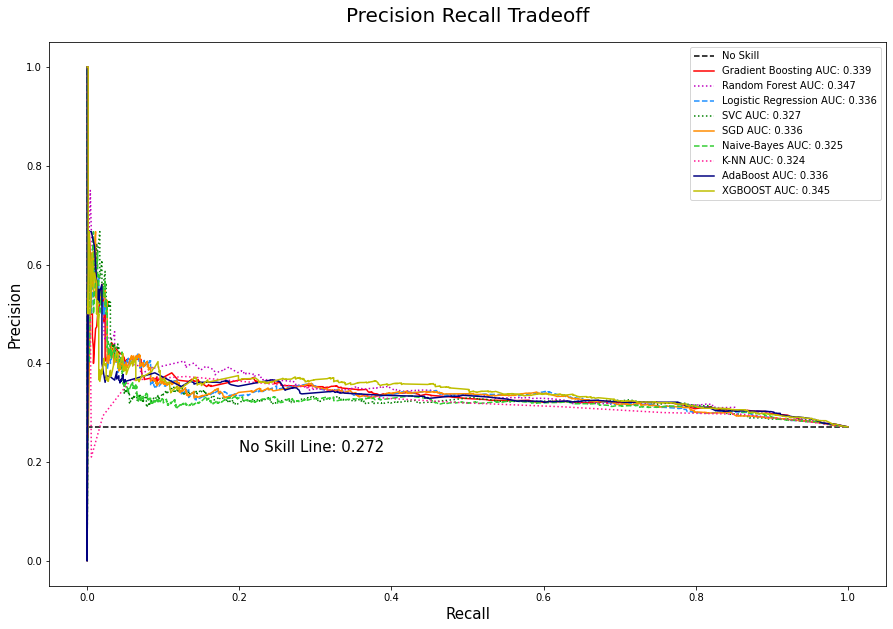

In [93]:
## Plotting the Precision / Recall Tradeoff 

names = ["Gradient Boosting","Random Forest","Logistic Regression","SVC","SGD","Naive-Bayes","K-NN","AdaBoost","XGBOOST"]
models = [gbc_best,rfc_best,best_lreg,svc_best,sgd_best,nb_best,knn_best,ada_best,xgb_best]
linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))

## Plotting the no-skill line. 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', c='black')

counter = 0
for name, model in zip(names,models):
    precision,recall,thresholds = precision_recall_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.plot(recall,precision,color=colors[counter], 
             linestyle=linestyles[counter], 
             label = name  +' AUC: %.3f'%auc(recall,precision))
    counter +=1


plt.title('Precision Recall Tradeoff', pad=20, fontsize = 20)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.annotate('No Skill Line: '+str(round(no_skill,3)),(0.2,0.22), fontsize =15)
plt.legend()
plt.show()

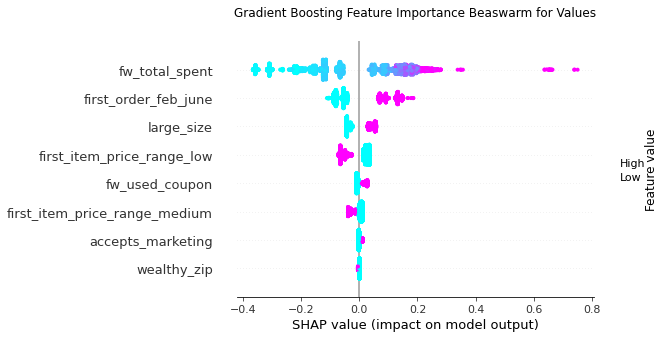

In [33]:
plt.title('Gradient Boosting Feature Importance Beaswarm for Values',pad = 25)
explainer = shap.Explainer(gbc_best)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, color = plt.get_cmap("cool"))

## Draft: 

## Random Forest

Metrics:
Accuracy Score: 0.7289
Accuracy Score at Threshold 37%: 0.5272
Precision Score: 1.0
Recall Score: 0.001
F1_Score Score: 0.003
ROC_AUC Score: 0.603
Log Loss Score: 9.365
MCC: 0.032


 Classification Report
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1929
           1       1.00      0.00      0.00       719

    accuracy                           0.73      2648
   macro avg       0.86      0.50      0.42      2648
weighted avg       0.80      0.73      0.61      2648



 Confusion Matrix
[[ 653 1276]
 [ 128  591]]



First 50 actuals: 
[1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 0 0]

 First 50 preds: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

 First 50 preds at threshold 0.37: 
[0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 1]

 First 50 pred probabili

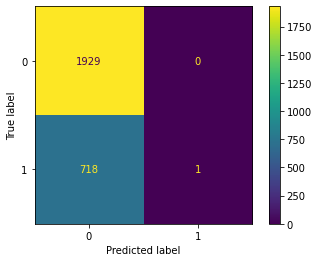

In [67]:
## Random Forest: 
rfc_best = RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= 4, 
                                  max_features= 'log2', n_estimators= 50, random_state = 42)

rfc_best.fit(X_train,y_train)
y_pred =rfc_best.predict(X_test)
y_pred_thresh_27 = (rfc_best.predict_proba(X_test)[:,1] >= 0.244).astype(int)
y_pred_proba = rfc_best.predict_proba(X_test)[:,1]

## Print out metrics 
print('Metrics:')
print('Accuracy Score: ' + str(round(accuracy_score(y_test,y_pred),4)))
print('Accuracy Score at Threshold 37%: '+ str(round(accuracy_score(y_test,y_pred_thresh_30),4)))
print('Precision Score: ' + str(round(precision_score(y_test,y_pred),3)))
print('Recall Score: ' + str(round(recall_score(y_test,y_pred),3)))
print('F1_Score Score: ' + str(round(f1_score(y_test,y_pred),3)))
print('ROC_AUC Score: ' + str(round(roc_auc_score(y_test,y_pred_proba),3)))
print('Log Loss Score: ' + str(round(log_loss(y_test,y_pred),3)))
print('MCC: ' + str(round(matthews_corrcoef(y_test,y_pred),3)))
print("\n\n Classification Report")
print(classification_report(y_test,y_pred))
print("\n\n Confusion Matrix")
print(confusion_matrix(y_test, y_pred_thresh_27))
print("\n\n")
print("First 50 actuals: ")
print(np.array(y_test[0:50]))
print("\n First 50 preds: ")
print(y_pred[0:50])
print("\n First 50 preds at threshold 0.37: ")
print(y_pred_thresh_30[0:50])
print("\n First 50 pred probabilities : ")
print(y_pred_proba[0:50])
print("\n")
plot_confusion_matrix(rfc_best,X_test,y_test)
plt.show()

Best Threshold=0.279322, G-Mean=0.572


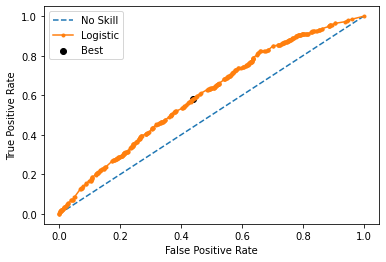

In [68]:
## Plotting the ROC curve and finding the best Threshold. 

fpr,tpr, threshold = roc_curve(y_test,y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

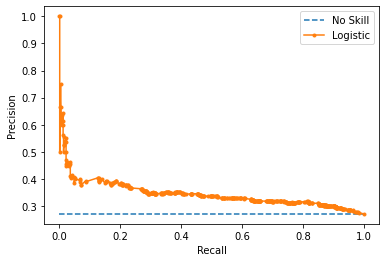

In [69]:
## Plotting Precision Recall Cur ve 
precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [70]:
y_pred_proba = rfc_best.predict_proba(X_test)
probs = y_pred_proba[:,1]
thresholds = np.arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
scores = [f1_score(y_test,to_labels(probs, t)) for t in thresholds]

ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.244, F-Score=0.45708


## GBC Best

Metrics:
Accuracy Score: 0.7289
Accuracy Score at Threshold 37%: 0.5272
Precision Score: 1.0
Recall Score: 0.001
F1_Score Score: 0.003
ROC_AUC Score: 0.603
Log Loss Score: 9.365
MCC: 0.032


 Classification Report
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1929
           1       1.00      0.00      0.00       719

    accuracy                           0.73      2648
   macro avg       0.86      0.50      0.42      2648
weighted avg       0.80      0.73      0.61      2648



 Confusion Matrix
[[ 551 1378]
 [ 113  606]]



First 50 actuals: 
[1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 0 0]

 First 50 preds: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

 First 50 preds at threshold 0.37: 
[0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 1]

 First 50 pred probabili

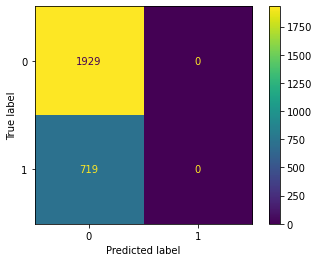

In [71]:
gbc_best = GradientBoostingClassifier(criterion= 'friedman_mse', max_depth= 2, 
                                      max_features= 'sqrt', n_estimators= 20, loss ='deviance',
                                      random_state = 42)

gbc_best.fit(X_train,y_train)
y_pred =rfc_best.predict(X_test)
y_pred_thresh_27 = (gbc_best.predict_proba(X_test)[:,1] >= 0.244).astype(int)
y_pred_proba = rfc_best.predict_proba(X_test)[:,1]

## Print out metrics 
print('Metrics:')
print('Accuracy Score: ' + str(round(accuracy_score(y_test,y_pred),4)))
print('Accuracy Score at Threshold 37%: '+ str(round(accuracy_score(y_test,y_pred_thresh_30),4)))
print('Precision Score: ' + str(round(precision_score(y_test,y_pred),3)))
print('Recall Score: ' + str(round(recall_score(y_test,y_pred),3)))
print('F1_Score Score: ' + str(round(f1_score(y_test,y_pred),3)))
print('ROC_AUC Score: ' + str(round(roc_auc_score(y_test,y_pred_proba),3)))
print('Log Loss Score: ' + str(round(log_loss(y_test,y_pred),3)))
print('MCC: ' + str(round(matthews_corrcoef(y_test,y_pred),3)))
print("\n\n Classification Report")
print(classification_report(y_test,y_pred))
print("\n\n Confusion Matrix")
print(confusion_matrix(y_test, y_pred_thresh_27))
print("\n\n")
print("First 50 actuals: ")
print(np.array(y_test[0:50]))
print("\n First 50 preds: ")
print(y_pred[0:50])
print("\n First 50 preds at threshold 0.37: ")
print(y_pred_thresh_30[0:50])
print("\n First 50 pred probabilities : ")
print(y_pred_proba[0:50])
print("\n")
plot_confusion_matrix(gbc_best,X_test,y_test)
plt.show()

Best Threshold=0.279322, G-Mean=0.572


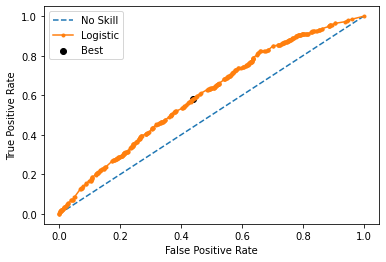

In [72]:
fpr,tpr, threshold = roc_curve(y_test,y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

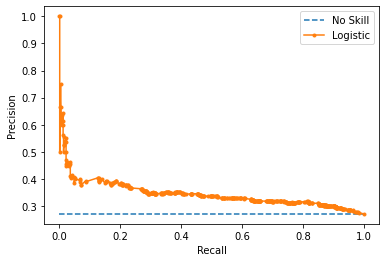

Threshold=0.247, F-Score=0.45221


In [73]:
precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

y_pred_proba = gbc_best.predict_proba(X_test)
probs = y_pred_proba[:,1]
thresholds = np.arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
scores = [f1_score(y_test,to_labels(probs, t)) for t in thresholds]

ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

## Logistic Regression

Metrics:
Accuracy Score: 0.7296
Accuracy Score at Threshold 37%: 0.5272
Precision Score: 0.636
Recall Score: 0.01
F1_Score Score: 0.019
ROC_AUC Score: 0.595
Log Loss Score: 9.339
MCC: 0.053


 Classification Report
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1929
           1       0.64      0.01      0.02       719

    accuracy                           0.73      2648
   macro avg       0.68      0.50      0.43      2648
weighted avg       0.70      0.73      0.62      2648



 Confusion Matrix
[[ 810 1119]
 [ 199  520]]



First 50 actuals: 
[1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 0 0]

 First 50 preds: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]

 First 50 preds at threshold 0.37: 
[0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 1]

 First 50 pred probabil

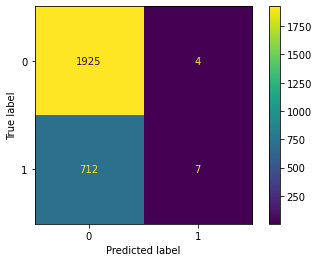

In [74]:
## Random Forest: 
best_lreg = LogisticRegression(C = 0.01, l1_ratio= 0, penalty = 'l2')

best_lreg.fit(X_train,y_train)
y_pred =best_lreg.predict(X_test)
y_pred_thresh_27 = (best_lreg.predict_proba(X_test)[:,1] >= 0.244).astype(int)
y_pred_proba = best_lreg.predict_proba(X_test)[:,1]

## Print out metrics 
print('Metrics:')
print('Accuracy Score: ' + str(round(accuracy_score(y_test,y_pred),4)))
print('Accuracy Score at Threshold 37%: '+ str(round(accuracy_score(y_test,y_pred_thresh_30),4)))
print('Precision Score: ' + str(round(precision_score(y_test,y_pred),3)))
print('Recall Score: ' + str(round(recall_score(y_test,y_pred),3)))
print('F1_Score Score: ' + str(round(f1_score(y_test,y_pred),3)))
print('ROC_AUC Score: ' + str(round(roc_auc_score(y_test,y_pred_proba),3)))
print('Log Loss Score: ' + str(round(log_loss(y_test,y_pred),3)))
print('MCC: ' + str(round(matthews_corrcoef(y_test,y_pred),3)))
print("\n\n Classification Report")
print(classification_report(y_test,y_pred))
print("\n\n Confusion Matrix")
print(confusion_matrix(y_test, y_pred_thresh_27))
print("\n\n")
print("First 50 actuals: ")
print(np.array(y_test[0:50]))
print("\n First 50 preds: ")
print(y_pred[0:50])
print("\n First 50 preds at threshold 0.37: ")
print(y_pred_thresh_30[0:50])
print("\n First 50 pred probabilities : ")
print(y_pred_proba[0:50])
print("\n")
plot_confusion_matrix(best_lreg,X_test,y_test)
plt.show()

Best Threshold=0.268309, G-Mean=0.586


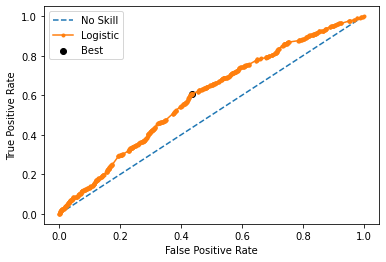

In [75]:
fpr,tpr, threshold = roc_curve(y_test,y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

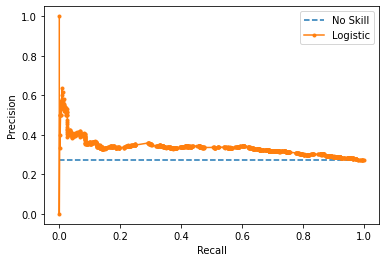

Threshold=0.223, F-Score=0.44707


In [76]:
## Plotting Precision Recall Cur ve 
precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

y_pred_proba = best_lreg.predict_proba(X_test)
probs = y_pred_proba[:,1]
thresholds = np.arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
scores = [f1_score(y_test,to_labels(probs, t)) for t in thresholds]

ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

In [77]:
from sklearn.metrics import confusion_matrix, fbeta_score


confusion_rfm = confusion_matrix(y_test, rfc_best.predict(X_test))
print(confusion_rfm)

[[1929    0]
 [ 718    1]]


In [78]:
def precision_recall(model, X_test, y_test, threshold, beta = 0.5):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = confusion_matrix(y_test, y_pred)
    
    print(threshold,'\n', matrix)
    
    tn = matrix[0,0]# customers that were predicted to not repeat and did not repeat.
    tp = matrix[1,1]# customers that were predicted to repeat and did repeat.
    fp = matrix[0,1]# customers that were predicted to repeat but did not repeat.
    fn = matrix[1,0]# customers that were predicted to not repeat but did repeat.
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [80]:
y_pred = (rfc_best.predict_proba(X_test)[:,1] >= 0.38).astype(bool)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1929
           1       0.45      0.02      0.04       719

    accuracy                           0.73      2648
   macro avg       0.59      0.51      0.44      2648
weighted avg       0.65      0.73      0.62      2648



In [87]:
threshold_df = pd.DataFrame(columns=['Precision','Recall','F0.5_measure'])

for threshold in np.arange(0.1,.9,.02):
    
    threshold_df.loc[threshold] = precision_recall(rfc_best, X_test, y_test, threshold)
print(threshold_df[0.1])

0.1 
 [[   0 1929]
 [   0  719]]
0.12000000000000001 
 [[   0 1929]
 [   0  719]]
0.14 
 [[   0 1929]
 [   0  719]]
0.16000000000000003 
 [[ 107 1822]
 [  17  702]]
0.18000000000000002 
 [[ 283 1646]
 [  49  670]]
0.2 
 [[ 357 1572]
 [  64  655]]
0.22000000000000003 
 [[ 469 1460]
 [  87  632]]
0.24000000000000002 
 [[ 538 1391]
 [ 106  613]]
0.26 
 [[ 798 1131]
 [ 190  529]]
0.28 
 [[1094  835]
 [ 307  412]]
0.30000000000000004 
 [[1498  431]
 [ 492  227]]
0.32000000000000006 
 [[1564  365]
 [ 517  202]]
0.3400000000000001 
 [[1696  233]
 [ 574  145]]
0.3600000000000001 
 [[1854   75]
 [ 669   50]]
0.38 
 [[1908   21]
 [ 702   17]]
0.4 
 [[1925    4]
 [ 712    7]]
0.42000000000000004 
 [[1928    1]
 [ 716    3]]
0.44000000000000006 
 [[1928    1]
 [ 717    2]]
0.4600000000000001 
 [[1928    1]
 [ 717    2]]
0.4800000000000001 
 [[1929    0]
 [ 718    1]]
0.5000000000000001 
 [[1929    0]
 [ 718    1]]
0.5200000000000001 
 [[1929    0]
 [ 718    1]]
0.54 
 [[1929    0]
 [ 719    0]]
0.

KeyError: 0.1

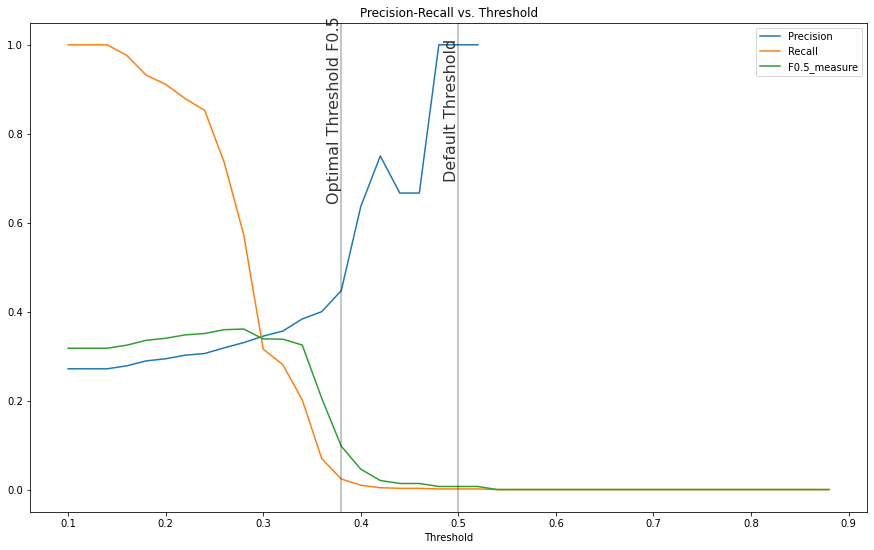

In [86]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold')
ax.axvline(0.38, color='black', alpha=0.3)
ax.text(.365,.65,'Optimal Threshold F0.5',rotation=90, alpha=0.8, fontsize=16)
ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.7,'Default Threshold',rotation=90, alpha=0.8,fontsize=16);

In [34]:
from sklearn.metrics import classification_report

def precision_recall(model, X_test, y_test, threshold, beta = 0.5):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = confusion_matrix(y_test, y_pred)
    
    print(threshold,'\n', matrix)
    
    tn = matrix[0,0]# customers that were predicted to be repeat but were not.
    tp = matrix[1,1]# pets that were predicted not to get adopted and didn't
    fp = matrix[0,1]# pets that were predicted not to get adopted but did
    fn = matrix[1,0]# pets that were predicted to get adopted but didn't
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [35]:
y_pred = (rfc_best.predict_proba(X_test)[:,1] >= 0.38).astype(bool)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1929
           1       0.45      0.02      0.04       719

    accuracy                           0.73      2648
   macro avg       0.59      0.51      0.44      2648
weighted avg       0.65      0.73      0.62      2648



In [36]:
threshold_df = pd.DataFrame(columns=['Precision','Recall','F0.5_measure'])

for threshold in np.arange(0.1,.9,.02):
    
    threshold_df.loc[threshold] = precision_recall(rfc_best, X_test, y_test, threshold)
 
print(threshold_df[0.1])

0.1 
 [[   0 1929]
 [   0  719]]
0.12000000000000001 
 [[   0 1929]
 [   0  719]]
0.14 
 [[   0 1929]
 [   0  719]]
0.16000000000000003 
 [[ 107 1822]
 [  17  702]]
0.18000000000000002 
 [[ 283 1646]
 [  49  670]]
0.2 
 [[ 357 1572]
 [  64  655]]
0.22000000000000003 
 [[ 469 1460]
 [  87  632]]
0.24000000000000002 
 [[ 538 1391]
 [ 106  613]]
0.26 
 [[ 798 1131]
 [ 190  529]]
0.28 
 [[1094  835]
 [ 307  412]]
0.30000000000000004 
 [[1498  431]
 [ 492  227]]
0.32000000000000006 
 [[1564  365]
 [ 517  202]]
0.3400000000000001 
 [[1696  233]
 [ 574  145]]
0.3600000000000001 
 [[1854   75]
 [ 669   50]]
0.38 
 [[1908   21]
 [ 702   17]]
0.4 
 [[1925    4]
 [ 712    7]]
0.42000000000000004 
 [[1928    1]
 [ 716    3]]
0.44000000000000006 
 [[1928    1]
 [ 717    2]]
0.4600000000000001 
 [[1928    1]
 [ 717    2]]
0.4800000000000001 
 [[1929    0]
 [ 718    1]]
0.5000000000000001 
 [[1929    0]
 [ 718    1]]
0.5200000000000001 
 [[1929    0]
 [ 718    1]]
0.54 
 [[1929    0]
 [ 719    0]]
0.

KeyError: 0.1

In [ ]:
y_pred = sum(rfc_best.predict_proba(X_test)[:,1] > 0.27)
y_pred

In [ ]:
pred = []
for model in [gbc_best,rfc_best,best_lreg,svc_best,sgd_best,nb_best,knn_best,ada_best,xgb_best]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction = pd.concat(pred,axis =1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))
    

In [ ]:
names = ["Gradient Boosting","Random Forest","Logistic Regression","SVC","SGD","Naive-Bayes","K-NN","AdaBoost","XGBOOST"]
probas = pd.concat(pred,axis=1)
probas.columns = names
probas

In [ ]:
final_prediction

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, final_prediction)
threshold

In [ ]:
accuracy_ls = []
for thres in threshold: 
    y_pred = np.where(final_prediction > thres,1,0)
    accuracy_ls.append(f1_score(y_test,y_pred))
    
accuracy_ls = pd.concat([pd.Series(threshold), pd.Series(accuracy_ls)], 
                        axis = 1)

accuracy_ls.columns = ['threshold','f1_score']
accuracy_ls.sort_values(by='f1_score', ascending = False, inplace = True)
accuracy_ls.head()
accuracy_ls

In [ ]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr,color='orange', label='ROC')
    plt.plot([0,1],[0,1], color='darkblue', linestyle ='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)

In [ ]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="constant")
dummy.fit(X_train,y_train)
dummy_preds = dummy.predict(X_test)
print(dummy.score(X_test,y_test))
print(f1_score(y_test,dummy_preds))

In [ ]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test,y_pred)